# Understanding `george`

For a comprehensive review of Gaussian Processes, see [this page](https://github.com/bmorris3/gp_interact) by Dr. Brett Morris.

In this notebook, I will try to fit KELT-11b transit observed by CHEOPS -- using GPs to decorrelate against various parameters, time and roll-angle. And in doing so, I will play with the functionalities of `george`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
from scipy.optimize import minimize as mz
import emcee
import corner
import batman
from george.modeling import Model

Let's first see, how our data looks like,

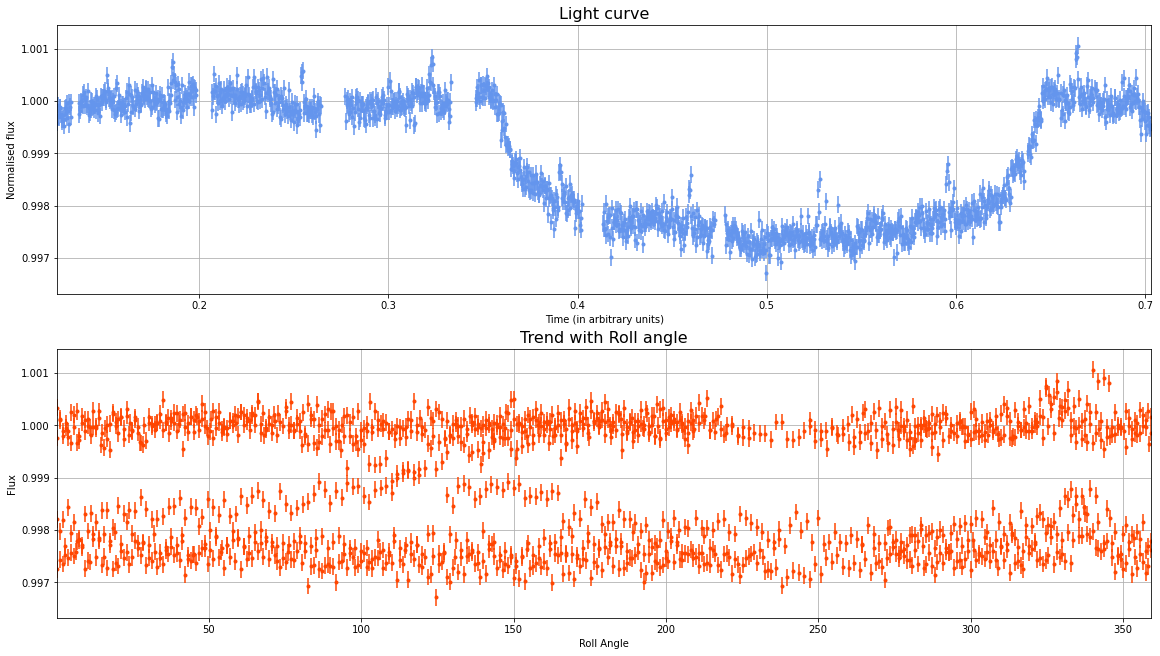

In [2]:
tim, fl, fle, roll = np.loadtxt('kelt-11.dat', usecols=(0,1,2,3), unpack=True)

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1,
                                    figsize=(16, 9), constrained_layout = True)

ax0.set_title('Light curve', fontsize=16)
ax0.errorbar(tim, fl, yerr=fle, fmt='.', c='cornflowerblue')
ax0.set_xlim([np.min(tim), np.max(tim)])
ax0.set_xlabel('Time (in arbitrary units)')
ax0.set_ylabel('Normalised flux')
ax0.grid()
#ax0.legend()

ax1.set_title('Trend with Roll angle', fontsize=16)
ax1.errorbar(roll, fl, yerr=fle, fmt='.', c='orangered')
ax1.set_xlim([np.min(roll), np.max(roll)])
ax1.set_xlabel('Roll Angle')
ax1.set_ylabel('Flux')
ax1.grid()
#plt.legend()

#fig.suptitle('Theoretical and empirical distributions of the estimate of parameters', fontsize=16)

Okay, so one can now clearly see a trend with roll angle in flux -- we want to model this lines using Gaussian processes. In addition to this, there is a trend with time, that is why we will use a multidimensional kernel to detrend this data and also fit a transit model simultaneously. We will use transit model from `batman` in this case.

In [3]:
# Transit model from george.modeling import Model

def transit_model_batman(rp, a, inc, q1, q2, t):
    params = batman.TransitParams()
    params.t0 = 0.50187268                       #time of inferior conjunction
    params.per = 4.73620495                      #orbital period
    params.rp = rp                               #planet radius (in units of stellar radii)
    params.a = a                                 #semi-major axis (in units of stellar radii)
    params.inc = inc                             #orbital inclination (in degrees)
    params.ecc = 0.                              #eccentricity
    params.w = 90.                               #longitude of periastron (in degrees)
    params.u = [q1, q2]                          #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"
    m = batman.TransitModel(params, t)           #initializes model
    flux = m.light_curve(params)                 #calculates light curve
    return flux

class transit(Model):
    parameter_names = ("rp", "a", "inc", "q1", "q2")   # This should be 'parameter_names' only

    # It's mandatory to give this function name "get_value"
    def get_value(self, tim):
        tim = tim.flatten()
        flx = transit_model_batman(self.rp, self.a, self.inc, self.q1, self.q2, tim)
        return flx

model = transit(rp=0.01, a=5., inc=80., q1=0.5, q2=0.5)

gp = george.GP(np.var(fl) * george.kernels.Matern32Kernel(10.0), mean=model)
gp.compute(tim, fle)

In [4]:
print(gp.get_parameter_names())      # To print parameter names
print(gp.get_parameter_vector())     # To print their present values

('mean:rp', 'mean:a', 'mean:inc', 'mean:q1', 'mean:q2', 'kernel:k1:log_constant', 'kernel:k2:metric:log_M_0_0')
[ 1.00000000e-02  5.00000000e+00  8.00000000e+01  5.00000000e-01
  5.00000000e-01 -1.34991316e+01  2.30258509e+00]


In [7]:
def lnprob2(p):
    gp.set_parameter_vector(p)
    return gp.log_likelihood(fl, quiet=True) + gp.log_prior()

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 15
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2)

print("Running first burn-in...")
p0 = initial + np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 200, progress=True)

print("Running second burn-in...")
p0 = p0[np.argmax(lp)] + np.random.randn(nwalkers, ndim)
sampler.reset()
p0, _, _ = sampler.run_mcmc(p0, 200, progress=True)
sampler.reset()

print("Running production...")
sampler.run_mcmc(p0, 200, progress=True);

Running first burn-in...


100%|██████████| 200/200 [04:10<00:00,  1.25s/it]


Running second burn-in...


100%|██████████| 200/200 [04:04<00:00,  1.22s/it]


Running production...


100%|██████████| 200/200 [03:56<00:00,  1.18s/it]


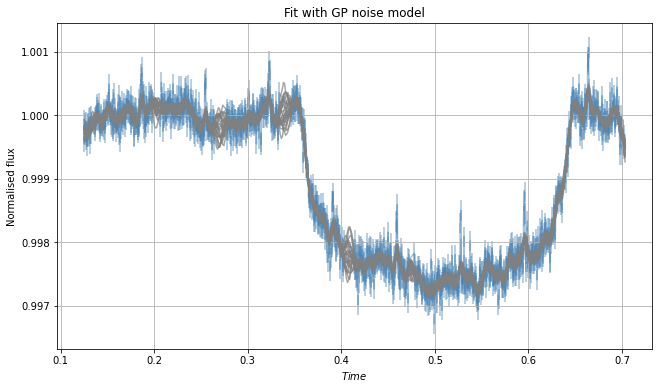

In [12]:
# Plot the data.
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim, fl, yerr=fle, fmt="steelblue", capsize=0, alpha=0.5, zorder=0)

# The positions where the prediction should be computed.
x = np.linspace(np.min(tim), np.max(tim), 500)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.sample_conditional(fl, x)
    plt.plot(x, mu, color="gray", alpha=0.7, zorder=5)

plt.ylabel("Normalised flux")
plt.xlabel(r"$Time$")
#plt.xlim(-5, 5)
plt.grid()
plt.title("Fit with GP noise model");

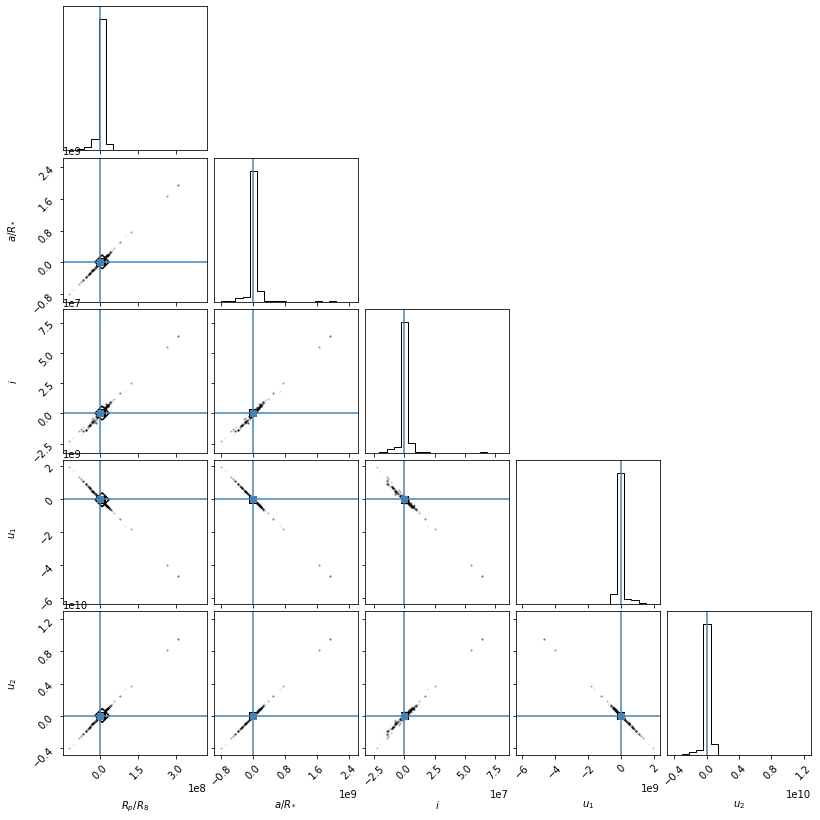

In [13]:
names = gp.get_parameter_names()
truth = dict(rp=0.04631917, a=4.96668512, inc=85.84343394610559, q1=0., q2=0.)
tri_cols = ["rp", "a", "inc", "q1", "q2"]
tri_labels = [r"$R_p/R_8$", r"$a/R_*$", r"$i$", r"$u_1$", r"$u_2$"]
tri_truths = [truth[k] for k in tri_cols]
#tri_range = [(-2, -0.01), (-3, -0.5), (-1, 1)]
inds = np.array([names.index("mean:"+k) for k in tri_cols])
corner.corner(sampler.flatchain[:, inds], truths=tri_truths, labels=tri_labels);

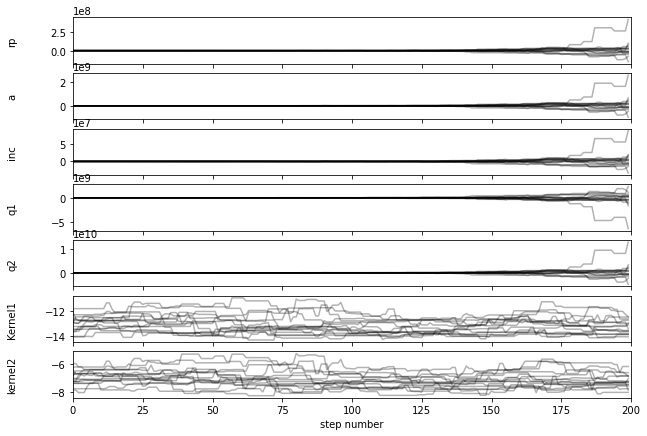

In [19]:
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = tri_cols + ['Kernel1', 'kernel2']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");